In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
xgb.__version__

''

In [4]:
df=pd.read_csv('../input/train2016_withy.csv')

In [5]:
df=df.loc[np.random.permutation(df.index)]

In [6]:
trainx=df.drop(['parcelid','logerror'],axis=1)
trainy=df['logerror']

In [7]:
trainx.shape

(90811, 95)

In [8]:
split = 80000
x_train, y_train, x_valid, y_valid = trainx[:split], trainy[:split], trainx[split:], trainy[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)




Building DMatrix...


In [9]:
print('Training ...')

params = {}
params['eta'] = 0.02
params['objective'] = 'reg:smoothl1'
#params['objective'] = 'reg:abs'
params['eval_metric'] = 'mae'
params['max_depth'] = 8
params['silent'] = 1
params['gamma'] = 2
params['min_child_weight']=50
params['tree_method']='hist'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 240, watchlist, early_stopping_rounds=50, verbose_eval=1)


Training ...
[0]	train-mae:0.478347	valid-mae:0.478896
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 50 rounds.
[1]	train-mae:0.459117	valid-mae:0.459653
[2]	train-mae:0.439937	valid-mae:0.440467
[3]	train-mae:0.420812	valid-mae:0.421329
[4]	train-mae:0.401754	valid-mae:0.40226
[5]	train-mae:0.38278	valid-mae:0.383265
[6]	train-mae:0.363896	valid-mae:0.364362
[7]	train-mae:0.345115	valid-mae:0.345554
[8]	train-mae:0.326447	valid-mae:0.326863
[9]	train-mae:0.307911	valid-mae:0.308312
[10]	train-mae:0.289528	valid-mae:0.289938
[11]	train-mae:0.271317	valid-mae:0.271758
[12]	train-mae:0.253296	valid-mae:0.253768
[13]	train-mae:0.235495	valid-mae:0.236016
[14]	train-mae:0.217946	valid-mae:0.218536
[15]	train-mae:0.20071	valid-mae:0.201365
[16]	train-mae:0.183827	valid-mae:0.184559
[17]	train-mae:0.167375	valid-mae:0.168173
[18]	train-mae:0.151427	valid-mae:0.152311
[19]	train-mae:0.1361	valid-mae:0.137081

In [10]:
0.991688/15.

0.06611253333333333

In [11]:
clf.best_ntree_limit

40

In [12]:
print clf.get_dump(dump_format='text')[7]

0:[finishedsquarefeet12<26] yes=1,no=2,missing=1
	1:[structuretaxvaluedollarcnt<17314] yes=3,no=4,missing=4
		3:[lotsizesquarefeet<86] yes=7,no=8,missing=8
			7:leaf=-0.015943
			8:leaf=-0.00987462
		4:[taxdelinquencyyear<13.5] yes=9,no=10,missing=10
			9:leaf=-0.0129233
			10:[taxvaluedollarcnt<2.30204e+06] yes=17,no=18,missing=17
				17:[propertyzoningdesc_S<0] yes=27,no=28,missing=27
					27:[calculatedfinishedsquarefeet<21] yes=39,no=40,missing=40
						39:leaf=-0.0150807
						40:[structuretaxvaluedollarcnt<38119] yes=55,no=56,missing=56
							55:[daysInYear1<182] yes=71,no=72,missing=71
								71:leaf=-0.0192888
								72:leaf=-0.0159619
							56:leaf=-0.0189874
					28:leaf=-0.0165679
				18:leaf=-0.0141202
	2:[taxamount<2850.9] yes=5,no=6,missing=6
		5:[yearbuilt<1928] yes=11,no=12,missing=11
			11:[taxdelinquencyyear<8.5] yes=19,no=20,missing=19
				19:leaf=-0.0180211
				20:leaf=-0.0134566
			12:leaf=-0.0191835
		6:[calculatedfinishedsquarefeet<81] yes=13,no=14,missing=13

In [15]:
import json
trees=[json.loads(u) for u in clf.get_dump(dump_format='json')[:clf.best_ntree_limit]]
len(trees)

40

In [16]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [ ]:
tree= (trees[7])

In [177]:
g=nx.DiGraph()

In [178]:
def addNode(node):
    g.add_node(node['nodeid'])
    if 'children' in node:
        for u in node['children']:
            addNode(u)
addNode(tree)            

In [179]:
def addEdge(node):
    n1=node['nodeid']
    if 'children' in node:
        for u in node['children']:
            g.add_edge(n1,u['nodeid'])
            addEdge(u)
addEdge(tree)            

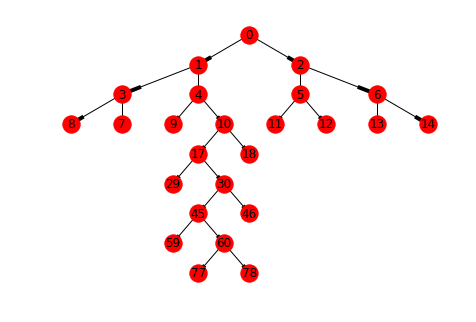

In [180]:
pos=graphviz_layout(g, prog='dot')
nx.draw(g,pos,with_labels=True)

In [17]:
def parse_tree(node):
    if 'leaf' in node:
        return [[]]
    nodeid=node['nodeid']
    split=node['split']
    split_cond=node['split_condition']
    yes=node['yes']
    no=node['no']
    missing=node['missing']
    children1=parse_tree([u for u in node["children"] if u['nodeid']==yes][0])
    children2=parse_tree([u for u in node["children"] if u['nodeid']==no][0])
    cond1=[('yes',split,split_cond)]
    cond2=[('no',split,split_cond)]
    if missing==yes:
        cond1.append(('missing',split))
    elif missing==no:
        cond2.append(('missing',split))
    else:
        raise 2
    ret1=[[cond1]+u for u in children1]
    ret2=[[cond2]+u for u in children2]
    return ret1+ret2
    
    

In [18]:
def enumerate_all_conds(tree):
    ret=[]
    cond_list=(parse_tree(tree))
    for cond in cond_list:
        for i in range(len(cond)):
            ret.append(cond[:i+1])
    return ret

In [20]:
cond_list=(enumerate_all_conds(trees[8]))
len(cond_list)

190

In [21]:
def value_cond_tuple (df,cond):
    #print cond
    col=cond[1]
    if cond[0]=='missing':
        return np.isnan(df[col])
    else:
        split_val=cond[2]
        if cond[0]=='yes':
            return df[col]<split_val
        elif cond[0]=='no':
            return df[col]>=split_val
        else:
            raise "never be here"
def value_cond_single(df,conds):
    return reduce(lambda u,v: u | v, [value_cond_tuple(df,cond) for cond in conds])
def value_cond(df,conds):
    return reduce(lambda u,v: u & v, [value_cond_single(df,cond) for cond in conds])
def value_trees(df,trees):
    cond_lists=reduce(lambda u,v: u+v, [enumerate_all_conds(tree) for tree in trees])
    return cond_lists, pd.DataFrame([value_cond(df, conds) for conds in cond_lists]).T

In [22]:
len(trees)

40

In [205]:
a,b=value_trees(df,trees)

In [206]:
b.shape

(90811, 20316)

In [207]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90811 entries, 67358 to 88387
Columns: 20316 entries, finishedsquarefeet12 to Unnamed 17430
dtypes: bool(20316)
memory usage: 1.7 GB


In [208]:
c=b.sum(0)

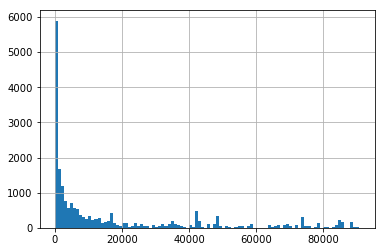

In [209]:
c.hist(bins=100)

In [210]:
c.min()

50

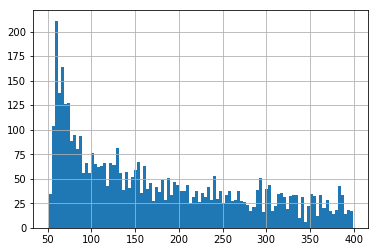

In [200]:
c[c<400].hist(bins=100)

In [211]:
len(a),len(b),b.shape

(20316, 90811, (90811, 20316))

In [320]:
X=np.concatenate([b.values[:,:5550],np.ones([b.shape[0],1])],axis=1)
y=trainy.values*15
X.shape,y.shape

((90811, 5551), (90811,))

In [321]:
W=None
def f(wb,g,*args):
    alpha=0
    w=wb.reshape([1,-1])

    
    pred= np.sum(w*X,1)
    
    d=pred-y
    a= np.sqrt(d**2+0.0001)
    v=np.mean(a)*1+0.5*alpha*np.mean(d**2)
    #print v, np.mean(d>0),a.mean(),np.abs(d).mean()
    #print d.shape,a.shape, 
    g1=((d/a)*1 + alpha*d).reshape([-1,1])
    g2= g1*X 
    
    meang=np.mean(g2,axis=0)
    g[:]=meang 
    global W
    W=w.copy()
    #print "AAA",v 
    return v
def progress(x, g, fx, xnorm, gnorm, step, k, ls):
    print  np.mean((fx-y)**2)/2,xnorm,gnorm,step,k,ls
    return 0

In [323]:

from lbfgs import LBFGS, LBFGSError, fmin_lbfgs
opt = LBFGS()
opt.max_iterations = 100
#opt.max_step=5
opt.linesearch='wolfe'
opt.orthantwise_c=0.001
opt.ftol

0.0001

In [324]:
opt.LINE_SEARCH_ALGORITHMS

['default', 'armijo', 'wolfe', 'morethuente', 'strongwolfe']

In [325]:
initials=np.random.random(size=[X.shape[1]])*0+1.0/X.shape[1]
try:
    abc=opt.minimize(f, initials,progress=progress)
except:
    pass

3.38332634437 0.0207955982168 2.27412567322 0.289081568382 1 1
3.38007850429 0.0159611606908 0.448540870408 1.0 2 1
3.37983159858 0.0159283739567 0.336309833854 1.0 3 1
3.37955585679 0.0161559283123 0.231488765253 1.0 4 1
3.37922154574 0.0159807219547 0.144166862568 1.0 5 1
3.37893342494 0.0179769282991 0.141517068939 1.0 6 1
3.3785953306 0.01972544079 0.140858333481 1.0 7 1
3.37857677348 0.0233006786009 0.6449654514 0.5 8 2
3.37839603377 0.0259747321971 0.509912013652 1.0 9 1
3.37822876819 0.0274462394208 0.089850104077 1.0 10 1
3.3782028542 0.0278276849606 0.0849571739601 1.0 11 1
3.37798910546 0.0344982519533 0.135767625253 1.0 12 1
3.37793082285 0.0372679435898 0.242967047302 1.0 13 1
3.37787200352 0.0393867566948 0.0511918016166 1.0 14 1
3.37781252158 0.0424347118214 0.0802033153358 1.0 15 1
3.37776865878 0.0530642734832 0.474972890616 1.0 16 1
3.37764118159 0.0601171331315 0.263006983123 1.0 17 1
3.3775692197 0.061890484718 0.0800873615496 1.0 18 1
3.3775165371 0.0647992224883 0.

Exception KeyboardInterrupt in 'lbfgs._lowlevel.call_eval' ignored


3.01238579392 0.0931214544666 0.165629934915 1.0 22 1


Exception KeyboardInterrupt in 'lbfgs._lowlevel.call_eval' ignored
Exception KeyboardInterrupt in 'lbfgs._lowlevel.call_eval' ignored
'lbfgs._lowlevel.call_eval''lbfgs._lowlevel.call_eval'Exception KeyboardInterrupt in 'lbfgs._lowlevel.call_eval' ignored
Exception KeyboardInterrupt in 'lbfgs._lowlevel.call_eval' ignored
Exception KeyboardInterrupt in 'lbfgs._lowlevel.call_eval' ignored
/home/spark/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: The line-search routine reaches the maximum number of evaluations.
  app.launch_new_instance()


In [329]:
np.mean(W!=0),W[0][-1]

(1.0, nan)

In [327]:
f(W,W*0)/15

nan

In [328]:
np.mean(((np.sum(W*X,1))-y)**2)/2,np.mean(np.abs((np.sum(W*X,1))-y))/15

(nan, nan)

In [310]:
(np.abs(y-y.mean())**2).mean()/2, (np.abs(y-np.median(y))).mean()/15

(2.9995368455551086, 0.069017504487341827)

In [331]:
import lbfgs
lbfgs.__file__

'/home/spark/anaconda2/lib/python2.7/site-packages/lbfgs/__init__.pyc'

In [213]:
from lbfgs import LBFGS, LBFGSError, fmin_lbfgs
def test_class_interface():
    def f(x, g, *args):
        g[:] =  4 * (x-2)
        return (x-2) ** 4 + 3

    opt = LBFGS()
    opt.max_iterations = 30

    print (opt.minimize(f, 1e6), [1])

 

In [145]:

from nose.tools import assert_equal, assert_greater, assert_raises
from numpy.testing import assert_array_equal, assert_array_almost_equal
def test_2d():
    def f(x, g, f_calls):
        #f_calls, = args
        assert_equal(x.shape, (2, 2))
        assert_equal(g.shape, x.shape)
        g[:] = 2 * x
        f_calls[0] += 1
        return (x ** 2).sum()

    def progress(x, g, fx, xnorm, gnorm, step, k, ls, p_calls):
        print "AAA",step,p_calls
        assert_equal(x.shape, (2, 2))
        assert_equal(g.shape, x.shape)

        assert_equal(np.sqrt((x ** 2).sum()), xnorm)
        assert_equal(np.sqrt((g ** 2).sum()), gnorm)

        p_calls[0] += 1
        return 0

    f_calls = [0]
    p_calls = [0]

    xmin = fmin_lbfgs(f, [[10., 100.], [44., 55.]], progress, args=[f_calls])
    print f_calls,p_calls
    assert_greater(f_calls, 0)
    assert_greater(p_calls, 0)
    assert_array_almost_equal(xmin, [[0, 0], [0, 0]])

In [146]:
test_2d()

AAA 0.0855583488641 [4]
AAA 1.0 [6]
[7] [0]


In [147]:
def test_class_interface():
    def f(x, g, *args):
        g[:] =  4 * x
        return x ** 4 + 1

    opt = LBFGS()
    opt.max_iterations = 3

    assert_array_equal(opt.minimize(f, 1e6), [0])

    opt.max_iterations = 1
    assert_raises(LBFGSError, opt.minimize, f, 1e7)


In [148]:
test_class_interface()